<a href="https://colab.research.google.com/github/yuuiwqy622/unsupervised-segmentation/blob/main/unsupervised_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%tensorflow_version 1.x
!pip install keras==2.1.5


TensorFlow is already loaded. Please restart the runtime to change versions.
     |████████████████████████████████| 337kB 9.1MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [3]:
!rm -rf sample_data

In [ ]:
!git clone https://github.com/NVIDIA/pix2pixHD.git

Cloning into 'pix2pixHD'...
remote: Enumerating objects: 340, done.
remote: Total 340 (delta 0), reused 0 (delta 0), pack-reused 340
Receiving objects: 100% (340/340), 55.68 MiB | 50.91 MiB/s, done.
Resolving deltas: 100% (156/156), done.


In [ ]:
!unzip reduced-isic.zip
!rm reduced-isic.zip

Archive:  reduced-isic.zip
   creating: reduced-isic/
   creating: reduced-isic/train_edge/
  inflating: reduced-isic/train_edge/ISIC_0000000.png  
  inflating: reduced-isic/train_edge/ISIC_0000001.png  
  inflating: reduced-isic/train_edge/ISIC_0000003.png  
  inflating: reduced-isic/train_edge/ISIC_0000006.png  
  inflating: reduced-isic/train_edge/ISIC_0000007.png  
  inflating: reduced-isic/train_edge/ISIC_0000009.png  
  inflating: reduced-isic/train_edge/ISIC_0000011.png  
  inflating: reduced-isic/train_edge/ISIC_0000013.png  
  inflating: reduced-isic/train_edge/ISIC_0000014.png  
  inflating: reduced-isic/train_edge/ISIC_0000015.png  
  inflating: reduced-isic/train_edge/ISIC_0000016.png  
  inflating: reduced-isic/train_edge/ISIC_0000018.png  
  inflating: reduced-isic/train_edge/ISIC_0000019.png  
  inflating: reduced-isic/train_edge/ISIC_0000020.png  
  inflating: reduced-isic/train_edge/ISIC_0000022.png  
  inflating: reduced-isic/train_edge/ISIC_0000023.png  
  inflating:

In [ ]:
import pathlib
import os
import sys
import time
import h5py
import random

import numpy as np
import tensorflow as tf
import keras
from keras import losses
from keras import models
import matplotlib.pyplot as plt

from skimage import color, exposure, io, img_as_float, transform, filters, morphology, measure
from sklearn import metrics

Using TensorFlow backend.


In [ ]:
def load_images(filepath):    
    '''
    Loads the available images.
    '''
    data_root = pathlib.Path(os.path.join(filepath))
    image_paths = [str(path) for path in  list(data_root.glob('*'))]
    return image_paths

In [ ]:
def preprocess_images(image_paths, savedir, load_prev=False):
    '''
    Preprocessing for ISIC images
    '''
    if not load_prev or not os.path.isdir(savedir):
        os.makedirs(savedir, exist_ok=True)
        for path in image_paths:
            savepath = os.path.join(savedir, os.path.basename(path))
            print(path)
            im = img_as_float(io.imread(path))        
            im = transform.resize(im, (256, 256), mode="reflect", anti_aliasing=True)
            im = np.uint8(im * 255)
            io.imsave(fname=savepath,arr=im)

In [ ]:
preprocess_images(load_images('reduced-isic/train_img'), 'train_img', load_prev=False)

reduced-isic/train_img/ISIC_0000021.jpg
reduced-isic/train_img/ISIC_0000026.jpg
reduced-isic/train_img/ISIC_0000027.jpg
reduced-isic/train_img/ISIC_0000023.jpg
reduced-isic/train_img/ISIC_0000022.jpg
reduced-isic/train_img/ISIC_0000029.jpg
reduced-isic/train_img/ISIC_0000013.jpg
reduced-isic/train_img/ISIC_0000003.jpg
reduced-isic/train_img/ISIC_0000024.jpg
reduced-isic/train_img/ISIC_0000015.jpg
reduced-isic/train_img/ISIC_0000001.jpg
reduced-isic/train_img/ISIC_0000032.jpg
reduced-isic/train_img/ISIC_0000004.jpg
reduced-isic/train_img/ISIC_0000028.jpg
reduced-isic/train_img/ISIC_0000031.jpg
reduced-isic/train_img/ISIC_0000000.jpg
reduced-isic/train_img/ISIC_0000030.jpg
reduced-isic/train_img/ISIC_0000007.jpg
reduced-isic/train_img/ISIC_0000025.jpg
reduced-isic/train_img/ISIC_0000016.jpg
reduced-isic/train_img/ISIC_0000017.jpg
reduced-isic/train_img/ISIC_0000011.jpg
reduced-isic/train_img/ISIC_0000012.jpg
reduced-isic/train_img/ISIC_0000006.jpg
reduced-isic/train_img/ISIC_0000020.jpg


In [ ]:
!pip install dominate

In [ ]:
!cp -r reduced-isic/train_edge train_label

In [ ]:
# # Step 4: Train pix2pixHD and choose the best epoch using the Frechet Inception Distance
# # This uses pytorch instead of tensorflow, so we run these steps externally using the pix2pixHD code provided by nVidia
print('Training pix2pixhD with only training images... ')
start = time.time()
# # Train command: python train.py --name pix2ultra --resize_or_crop none --checkpoints_dir pix2ultra/checkpoints --dataroot pix2ultra/datasets/isic2018/ --nThreads 4 --display_winsize 256 --tf_log --no_instance --label_nc 2
!python pix2pixHD/train.py --name pix2ultra --resize_or_crop none --checkpoints_dir pix2ultra/checkpoints --dataroot ./ --nThreads 2 --display_winsize 256 --tf_log --no_instance --label_nc 2
# # FID command: python fid.py path/to/images path/to/other/images --gpu 0
end = time.time()
print('took {} seconds'.format(end-start))

Training pix2pixhD with only training images... 
------------ Options -------------
batchSize: 1
beta1: 0.5
checkpoints_dir: pix2ultra/checkpoints
continue_train: False
data_type: 32
dataroot: ./
debug: False
display_freq: 100
display_winsize: 256
feat_num: 3
fineSize: 512
fp16: False
gpu_ids: [0]
input_nc: 3
instance_feat: False
isTrain: True
label_feat: False
label_nc: 2
lambda_feat: 10.0
loadSize: 1024
load_features: False
load_pretrain: 
local_rank: 0
lr: 0.0002
max_dataset_size: inf
model: pix2pixHD
nThreads: 2
n_blocks_global: 9
n_blocks_local: 3
n_clusters: 10
n_downsample_E: 4
n_downsample_global: 4
n_layers_D: 3
n_local_enhancers: 1
name: pix2ultra
ndf: 64
nef: 16
netG: global
ngf: 64
niter: 100
niter_decay: 100
niter_fix_global: 0
no_flip: False
no_ganFeat_loss: False
no_html: False
no_instance: True
no_lsgan: False
no_vgg_loss: False
norm: instance
num_D: 2
output_nc: 3
phase: train
pool_size: 0
print_freq: 100
resize_or_crop: none
save_epoch_freq: 10
save_latest_freq: 1000


In [ ]:
!ls pix2ultra/checkpoints/pix2ultra
# !zip -r pix2pix-check pix2ultra/checkpoints/

200_net_D.pth  iter.txt		 latest_net_G.pth  loss_log.txt  web
200_net_G.pth  latest_net_D.pth  logs		   opt.txt


In [ ]:
# Step 5: Use the trained pix2pixHD model to generate synthetic ultrasound images from the synthetic edge diagrams
print(' all images... ')
start = time.time()
# Test command: python test.py --name pix2ultra --resize_or_crop none --checkpoints_dir pix2ultra/checkpoints --results_dir pix2ultra/results --how_many 3000 --dataroot pix2ultra/datasets/isic2018/ --display_winsize 256 --no_instance --label_nc 2
!python pix2pixHD/test.py --name pix2ultra --resize_or_crop none --checkpoints_dir pix2ultra/checkpoints --results_dir pix2ultra/results --how_many 30 --dataroot ./ --display_winsize 256 --no_instance --label_nc 2
end = time.time() 
print('took {} seconds'.format(end-start))

 all images... 
------------ Options -------------
aspect_ratio: 1.0
batchSize: 1
checkpoints_dir: pix2ultra/checkpoints
cluster_path: features_clustered_010.npy
data_type: 32
dataroot: ./
display_winsize: 256
engine: None
export_onnx: None
feat_num: 3
fineSize: 512
fp16: False
gpu_ids: [0]
how_many: 30
input_nc: 3
instance_feat: False
isTrain: False
label_feat: False
label_nc: 2
loadSize: 1024
load_features: False
local_rank: 0
max_dataset_size: inf
model: pix2pixHD
nThreads: 2
n_blocks_global: 9
n_blocks_local: 3
n_clusters: 10
n_downsample_E: 4
n_downsample_global: 4
n_local_enhancers: 1
name: pix2ultra
nef: 16
netG: global
ngf: 64
niter_fix_global: 0
no_flip: False
no_instance: True
norm: instance
ntest: inf
onnx: None
output_nc: 3
phase: test
resize_or_crop: none
results_dir: pix2ultra/results
serial_batches: False
tf_log: False
use_dropout: False
use_encoded_image: False
verbose: False
which_epoch: latest
-------------- End ----------------
CustomDatasetDataLoader
dataset [Aligne

In [ ]:
!zip -r result.zip pix2ultra/results/pix2ultra/test_latest

  adding: pix2ultra/results/pix2ultra/test_latest/ (stored 0%)
  adding: pix2ultra/results/pix2ultra/test_latest/images/ (stored 0%)
  adding: pix2ultra/results/pix2ultra/test_latest/images/18_synthesized_image.jpg (deflated 2%)
  adding: pix2ultra/results/pix2ultra/test_latest/images/3_input_label.jpg (deflated 58%)
  adding: pix2ultra/results/pix2ultra/test_latest/images/12_synthesized_image.jpg (deflated 2%)
  adding: pix2ultra/results/pix2ultra/test_latest/images/21_input_label.jpg (deflated 54%)
  adding: pix2ultra/results/pix2ultra/test_latest/images/23_synthesized_image.jpg (deflated 2%)
  adding: pix2ultra/results/pix2ultra/test_latest/images/14_input_label.jpg (deflated 58%)
  adding: pix2ultra/results/pix2ultra/test_latest/images/21_synthesized_image.jpg (deflated 3%)
  adding: pix2ultra/results/pix2ultra/test_latest/images/0_synthesized_image.jpg (deflated 2%)
  adding: pix2ultra/results/pix2ultra/test_latest/images/1_synthesized_image.jpg (deflated 2%)
  adding: pix2ultra/r

In [ ]:
!mv test_latest result

In [ ]:
!git clone https://github.com/matterport/Mask_RCNN.git

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 125.23 MiB | 39.07 MiB/s, done.
Resolving deltas: 100% (562/562), done.


In [ ]:
!mv Mask_RCNN/mrcnn .
!rm -rf Mask_RCNN

In [ ]:
!unzip result.zip
!rm result.zip
!mv result/pix2ultra/results/result/test_latest res
!rm -rf result
!mv res result

Archive:  result.zip
   creating: result/
   creating: result/pix2ultra/
   creating: result/pix2ultra/results/
   creating: result/pix2ultra/results/result/
   creating: result/pix2ultra/results/result/test_latest/
   creating: result/pix2ultra/results/result/test_latest/images/
  inflating: result/pix2ultra/results/result/test_latest/images/18_synthesized_image.jpg  
  inflating: result/pix2ultra/results/result/test_latest/images/3_input_label.jpg  
  inflating: result/pix2ultra/results/result/test_latest/images/12_synthesized_image.jpg  
  inflating: result/pix2ultra/results/result/test_latest/images/21_input_label.jpg  
  inflating: result/pix2ultra/results/result/test_latest/images/23_synthesized_image.jpg  
  inflating: result/pix2ultra/results/result/test_latest/images/14_input_label.jpg  
  inflating: result/pix2ultra/results/result/test_latest/images/21_synthesized_image.jpg  
  inflating: result/pix2ultra/results/result/test_latest/images/0_synthesized_image.jpg  
  inflating

In [4]:
!unzip synth_.zip
!rm synth_.zip

Archive:  synth_.zip
   creating: synth_image/
  inflating: synth_image/0_synthesized_image.jpg  
  inflating: synth_image/1_synthesized_image.jpg  
  inflating: synth_image/2_synthesized_image.jpg  
  inflating: synth_image/3_synthesized_image.jpg  
  inflating: synth_image/4_synthesized_image.jpg  
  inflating: synth_image/5_synthesized_image.jpg  
  inflating: synth_image/6_synthesized_image.jpg  
  inflating: synth_image/7_synthesized_image.jpg  
  inflating: synth_image/8_synthesized_image.jpg  
  inflating: synth_image/9_synthesized_image.jpg  
  inflating: synth_image/10_synthesized_image.jpg  
  inflating: synth_image/11_synthesized_image.jpg  
  inflating: synth_image/12_synthesized_image.jpg  
  inflating: synth_image/13_synthesized_image.jpg  
  inflating: synth_image/14_synthesized_image.jpg  
  inflating: synth_image/15_synthesized_image.jpg  
  inflating: synth_image/16_synthesized_image.jpg  
  inflating: synth_image/17_synthesized_image.jpg  
  inflating: synth_image/18

In [1]:
%tensorflow_version 1.x
!pip install keras==2.1.5

TensorFlow 1.x selected.
  Using cached https://files.pythonhosted.org/packages/ba/65/e4aff762b8696ec0626a6654b1e73b396fcc8b7cc6b98d78a1bc53b85b48/Keras-2.1.5-py2.py3-none-any.whl
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


from https://colab.research.google.com/github/zaidalyafeai/Notebooks/blob/master/unet.ipynb#scrollTo=P8tq55g677wp

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from keras.layers import  Dropout, Activation
from keras.optimizers import Adam, SGD
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.utils import plot_model
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle

Using TensorFlow backend.


In [14]:
def image_generator(files, batch_size = 32, sz = (256, 256)):
  
  while True: 
    
    #extract a random batch 
    batch = np.random.choice(files, size = batch_size)    
    
    #variables for collecting batches of inputs and outputs 
    batch_x = []
    batch_y = []
    
    
    for f in batch:

        #get the masks. Note that masks are png files 
        mask = Image.open(f'synth_mask/{f[:-22]}.png')
        mask = np.array(mask.resize(sz))


        #preprocess the mask 
        mask[mask > 0] = 1
        # mask[mask != 0 ] = 1
        
        batch_y.append(mask)

        #preprocess the raw images 
        raw = Image.open(f'synth_image/{f}')
        # raw = raw.resize(sz)
        raw = np.array(raw)

        #check the number of channels because some of the images are RGBA or GRAY
        if len(raw.shape) == 2:
          raw = np.stack((raw,)*3, axis=-1)

        else:
          raw = raw[:,:,0:3]

        batch_x.append(raw)

    #preprocess a batch of images and masks 
    batch_x = np.array(batch_x)/255.
    batch_y = np.array(batch_y)
    batch_y = np.expand_dims(batch_y,3)

    yield (batch_x, batch_y)

In [15]:
batch_size = 1

all_files = os.listdir('synth_image')
shuffle(all_files)

split = int(0.95 * len(all_files))

#split into training and testing
train_files = all_files[0:split]
test_files  = all_files[split:]

train_generator = image_generator(train_files, batch_size = batch_size)
test_generator  = image_generator(test_files, batch_size = batch_size)

In [16]:
x, y= next(train_generator)

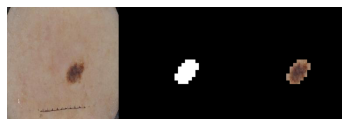

In [6]:
plt.axis('off')
img = x[0]
msk = y[0].squeeze()
msk = np.stack((msk,)*3, axis=-1)

plt.imshow( np.concatenate([img, msk, img*msk], axis = 1))

In [17]:
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

In [18]:
def unet(sz = (256, 256, 3)):
  x = Input(sz)
  inputs = x
  
  #down sampling 
  f = 8
  layers = []
  
  for i in range(0, 6):
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    layers.append(x)
    x = MaxPooling2D() (x)
    f = f*2
  ff2 = 64 
  
  #bottleneck 
  j = len(layers) - 1
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
  x = Concatenate(axis=3)([x, layers[j]])
  j = j -1 
  
  #upsampling 
  for i in range(0, 5):
    ff2 = ff2//2
    f = f // 2 
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
    x = Concatenate(axis=3)([x, layers[j]])
    j = j -1 
    
  
  #classification 
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  outputs = Conv2D(1, 1, activation='sigmoid') (x)
  
  #model creation 
  model = Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = [mean_iou])
  
  return model

In [19]:
model = unet()

In [20]:
def build_callbacks():
        checkpointer = ModelCheckpoint(filepath='unet.h5', verbose=0, save_best_only=True, save_weights_only=True)
        callbacks = [checkpointer, PlotLearning()]
        return callbacks

# inheritance for training process plot 
class PlotLearning(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        #self.fig = plt.figure()
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('mean_iou'))
        self.val_acc.append(logs.get('val_mean_iou'))
        self.i += 1
        print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),'mean_iou=',logs.get('mean_iou'),'val_mean_iou=',logs.get('val_mean_iou'))
        
        #choose a random test image and preprocess
        path = np.random.choice(test_files)
        raw = Image.open(f'synth_image/{path}')
        raw = np.array(raw.resize((256, 256)))/255.
        raw = raw[:,:,0:3]
        
        #predict the mask 
        pred = model.predict(np.expand_dims(raw, 0))
        
        #mask post-processing 
        msk  = pred.squeeze()
        msk = np.stack((msk,)*3, axis=-1)
        msk[msk >= 0.5] = 1 
        msk[msk < 0.5] = 0 
        
        #show the mask and the segmented image 
        combined = np.concatenate([raw, msk, raw* msk], axis = 1)
        plt.axis('off')
        plt.imshow(combined)
        plt.show()

i= 1 loss= 0.5259316552962575 val_loss= 0.5533876419067383 mean_iou= 0.0 val_mean_iou= 0.0


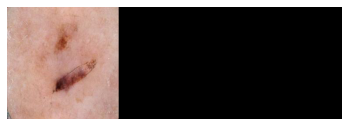

i= 2 loss= 0.4279421014445169 val_loss= 0.3374243378639221 mean_iou= 0.0 val_mean_iou= 0.0


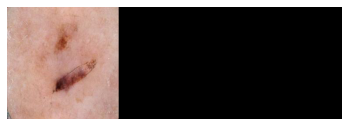

i= 3 loss= 0.48330626423869816 val_loss= 0.37026411294937134 mean_iou= 0.04993670067882964 val_mean_iou= 0.005011792294681072


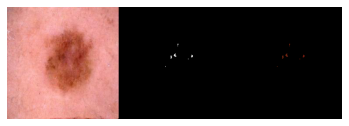

i= 4 loss= 0.36367874991680893 val_loss= 0.2151913344860077 mean_iou= 0.2518144830901292 val_mean_iou= 0.39371900260448456


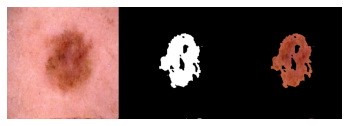

i= 5 loss= 0.3797026912548712 val_loss= 0.3190157413482666 mean_iou= 0.38147332128885736 val_mean_iou= 0.7570508122444153


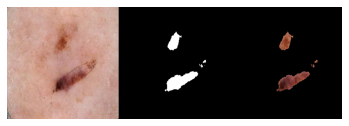

i= 6 loss= 0.3240667158471687 val_loss= 0.43529146909713745 mean_iou= 0.5018511663324067 val_mean_iou= 0.7969762682914734


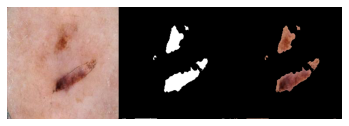

i= 7 loss= 0.27867793584508554 val_loss= 0.2521994709968567 mean_iou= 0.5082830927733865 val_mean_iou= 0.7689728736877441


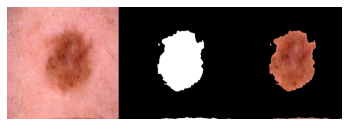

i= 8 loss= 0.3833860930587564 val_loss= 0.43987607955932617 mean_iou= 0.5938605070363597 val_mean_iou= 0.44222599267959595


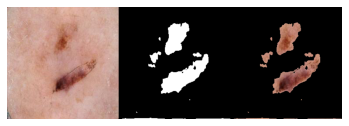

i= 9 loss= 0.3044550535934312 val_loss= 0.6281441450119019 mean_iou= 0.6176865721936338 val_mean_iou= 0.3266141712665558


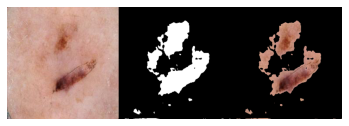

i= 10 loss= 0.2976736432340528 val_loss= 0.2110089808702469 mean_iou= 0.5414364790277821 val_mean_iou= 0.8409122824668884


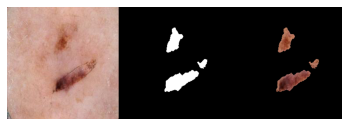

i= 11 loss= 0.36930390926344053 val_loss= 0.21928061544895172 mean_iou= 0.47523613260792835 val_mean_iou= 0.6655137687921524


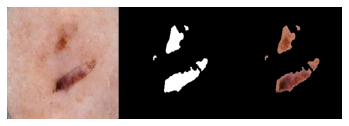

i= 12 loss= 0.327780617667096 val_loss= 0.14063633605837822 mean_iou= 0.5249477697403303 val_mean_iou= 0.6022205203771591


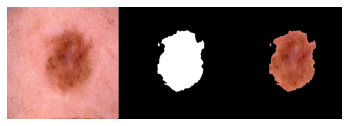

i= 13 loss= 0.23616985843649932 val_loss= 0.1344611868262291 mean_iou= 0.6703280637572918 val_mean_iou= 0.5314234793186188


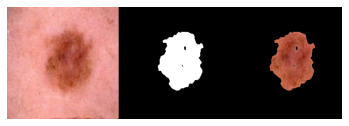

i= 14 loss= 0.287259079515934 val_loss= 0.12132570892572403 mean_iou= 0.6273670797236264 val_mean_iou= 0.6112098842859268


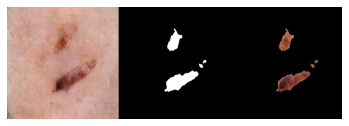

i= 15 loss= 0.2454191212143217 val_loss= 0.24323204159736633 mean_iou= 0.6445997801742384 val_mean_iou= 0.5990820378065109


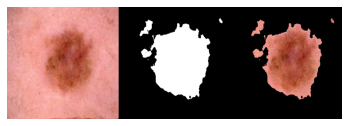

i= 16 loss= 0.2514716775289604 val_loss= 0.11628931388258934 mean_iou= 0.5870772751846484 val_mean_iou= 0.6295211613178253


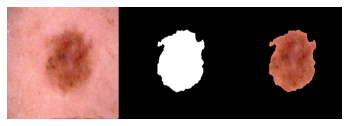

i= 17 loss= 0.19763281023395912 val_loss= 0.2179400473833084 mean_iou= 0.5753237368272883 val_mean_iou= 0.6058663725852966


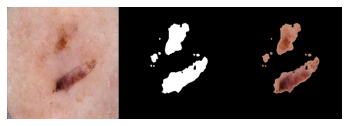

i= 18 loss= 0.22322319527821882 val_loss= 0.1216840147972107 mean_iou= 0.6578448755400521 val_mean_iou= 0.8297390937805176


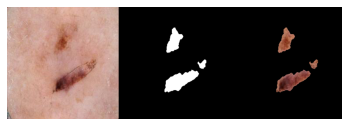

i= 19 loss= 0.2035174582685743 val_loss= 0.18018397688865662 mean_iou= 0.6051374762984258 val_mean_iou= 0.47534069418907166


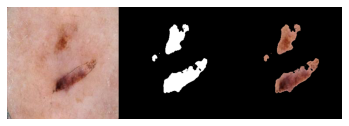

i= 20 loss= 0.23081254214048386 val_loss= 0.13299551606178284 mean_iou= 0.6537966004439763 val_mean_iou= 0.8160365223884583


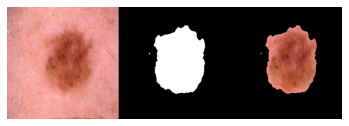

i= 21 loss= 0.2040803977953536 val_loss= 0.25435250252485275 mean_iou= 0.6916037541814148 val_mean_iou= 0.5091236978769302


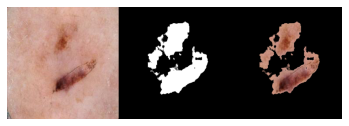

i= 22 loss= 0.15872469624238356 val_loss= 0.25681859254837036 mean_iou= 0.6738355979323387 val_mean_iou= 0.3011748194694519


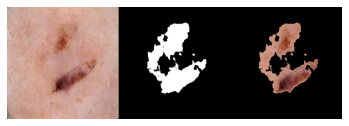

i= 23 loss= 0.19257544047598327 val_loss= 0.1607520505785942 mean_iou= 0.7020321126495089 val_mean_iou= 0.6330502778291702


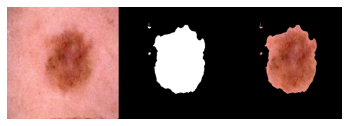

i= 24 loss= 0.24978771892243198 val_loss= 0.11450135707855225 mean_iou= 0.6600226245022246 val_mean_iou= 0.3670385777950287


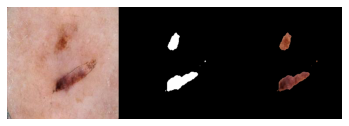

i= 25 loss= 0.5679197423160076 val_loss= 0.13449150323867798 mean_iou= 0.5848500699337039 val_mean_iou= 0.6491707414388657


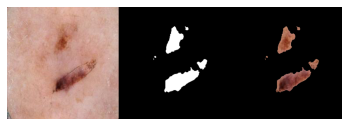

i= 26 loss= 0.19489625229367188 val_loss= 0.12339156121015549 mean_iou= 0.7371187095663377 val_mean_iou= 0.5888958871364594


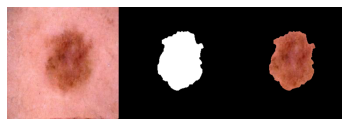

i= 27 loss= 0.20018020897571528 val_loss= 0.4171890616416931 mean_iou= 0.6554550283721515 val_mean_iou= 0.5532312989234924


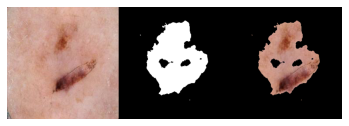

i= 28 loss= 0.20412325845765217 val_loss= 0.11672616004943848 mean_iou= 0.6426997373013624 val_mean_iou= 0.820233941078186


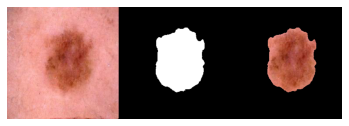

i= 29 loss= 0.25159311214728014 val_loss= 0.18910422176122665 mean_iou= 0.6008456634091479 val_mean_iou= 0.6343133300542831


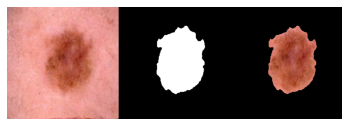

i= 30 loss= 0.18641730131847517 val_loss= 3.0483407974243164 mean_iou= 0.6287904589303902 val_mean_iou= 0.41091492772102356


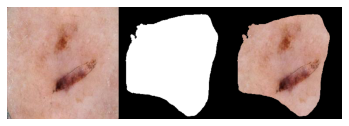

In [21]:
train_steps = len(train_files) //batch_size
test_steps = len(test_files) //batch_size
model.fit_generator(train_generator, 
                    epochs = 30, steps_per_epoch = train_steps,validation_data = test_generator, validation_steps = test_steps,
                    callbacks = build_callbacks(), verbose = 0)

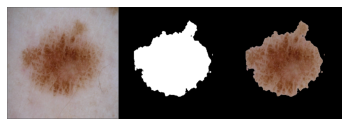

In [31]:
raw = Image.open('ISIC_0000022.jpg')
raw = np.array(raw.resize((256, 256)))/255.
raw = raw[:,:,0:3]

#predict the mask 
pred = model.predict(np.expand_dims(raw, 0))

#mask post-processing 
msk  = pred.squeeze()
msk = np.stack((msk,)*3, axis=-1)
msk[msk >= 0.5] = 1 
msk[msk < 0.5] = 0 

#show the mask and the segmented image 
combined = np.concatenate([raw, msk, raw* msk], axis = 1)
plt.axis('off')
plt.imshow(combined)
plt.show()